In [1]:
# Install VELO SDK for easy API access
%pip install velo-sdk plotly seaborn kaleido python-dotenv --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Relay Colab secret to os.environ to keep the core logic vendor free
try:
    import os
    from google.colab import userdata

    os.environ["RISKTHINKING_API_KEY"] = userdata.get("RISKTHINKING_API_KEY")
except:
    # likely not in Google Colab, attempt to load from local .env
    from dotenv import load_dotenv

    load_dotenv()
    pass

In [3]:
# Instantiate the VELO API client and look up a company
from velo_sdk.api import APIClient

client = APIClient()  # VELO SDK auto detects $RISKTHINKING_API_KEY env var

company = client.companies.search_companies(name="Apple", limit=1)[0]
company

Company(id='8a22d3a4-13fb-4758-bf0f-61e3f51d01f6', name='Apple Inc', slug='apple-inc', headquarters_address='One Apple Park Way , Cupertino, 95014, United States', organization_id=None, market_cap=2580000000000, annual_revenue=394328000000, headquarters_country='US', sector='Information Technology', isin_codes=['CA03785Y1007', 'BRAAPLBDR004', 'US0378331005', 'ARDEUT116183'], figi_codes=[], cik_code='', lei_code='', stock_tickers=['AAPLD', 'AAPL34', 'APC', 'AP-U', 'AAPLE', 'AAPLm', 'APC8', 'AAPL_KZTQBD', 'AAPL_KZ', 'AAPL *', 'AAPL', '000908440', '0R2V', 'APPL', 'AAPLCL'], is_grandparent=None, data_generated_at=None, data_generation_status=None, created_at='2025-02-14T00:20:08.262922', updated_at='2025-04-29T22:03:35.271222')

In [4]:
# Get climate scores (by country) iterator, which handles pagination conveniently
countries = client.companies.aggregate_company_asset_climate_scores_by_country(
    company.id, pathway="SV", horizon=2050
)

In [5]:
# Leverage a Polars DataFrame to easily ingest all the scores
import polars as pl

df = pl.DataFrame(countries)
df

dcr_score,expected_impact,cvar_99,cvar_95,cvar_50,var_99,var_95,var_50,asset_count,country
f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.883227,0.140136,0.242994,0.222187,0.149381,0.240561,0.205868,0.114446,37,"""USA"""
0.0,0.11661,0.178969,0.151021,0.141095,0.178464,0.14182,0.139597,1,"""HUN"""
0.913771,0.144678,0.241695,0.224131,0.171809,0.237034,0.219873,0.138932,403,"""CHN"""
0.987497,0.036706,0.071477,0.071477,0.038703,0.071477,0.071477,0.027842,1,"""ISR"""
0.932919,0.045913,0.09057,0.055666,0.055666,0.08831,0.054756,0.054756,2,"""CAN"""
…,…,…,…,…,…,…,…,…,…
0.806343,0.005342,0.031157,0.013311,0.008263,0.025399,0.009032,0.00749,2,"""BEL"""
0.811693,0.304165,0.471832,0.471457,0.471457,0.47183,0.471446,0.471446,2,"""TWN"""
0.944739,0.013582,0.019589,0.019589,0.016502,0.01845,0.01845,0.01587,1,"""ITA"""


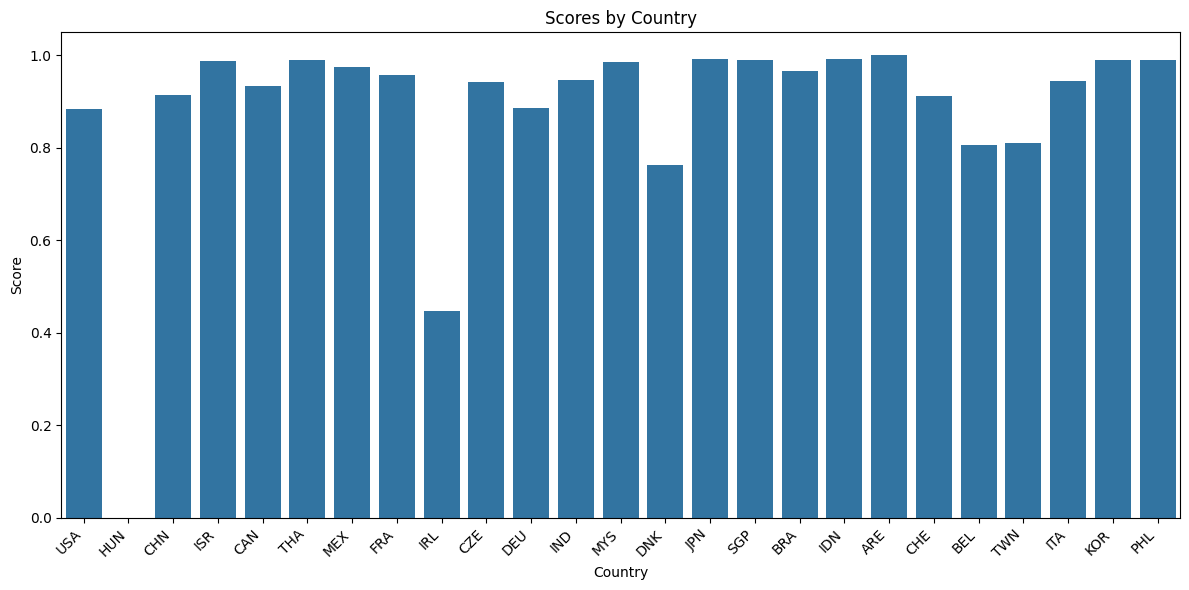

In [6]:
# Plain bar charts comparing DCR scores across countries
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x="country", y="dcr_score", data=df)
plt.title("Scores by Country")
plt.xlabel("Country")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

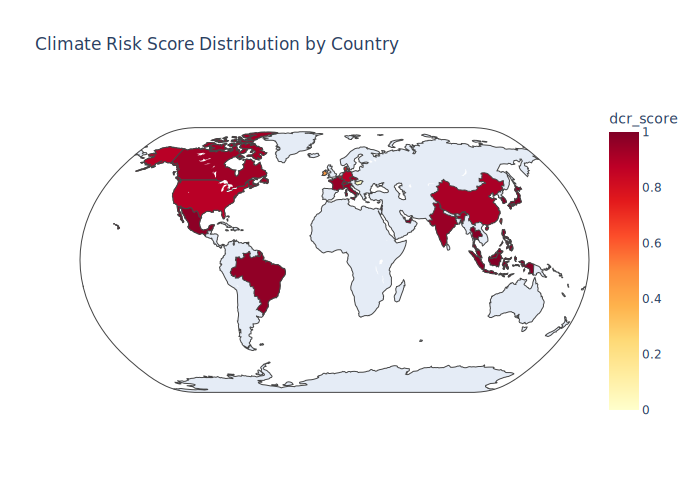

In [7]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "svg"

fig = px.choropleth(
    df,
    locations="country",
    color="dcr_score",
    hover_name="country",
    color_continuous_scale=px.colors.sequential.YlOrRd,
    title="Climate Risk Score Distribution by Country",
)
fig.update_geos(projection_type="natural earth")
fig.show()

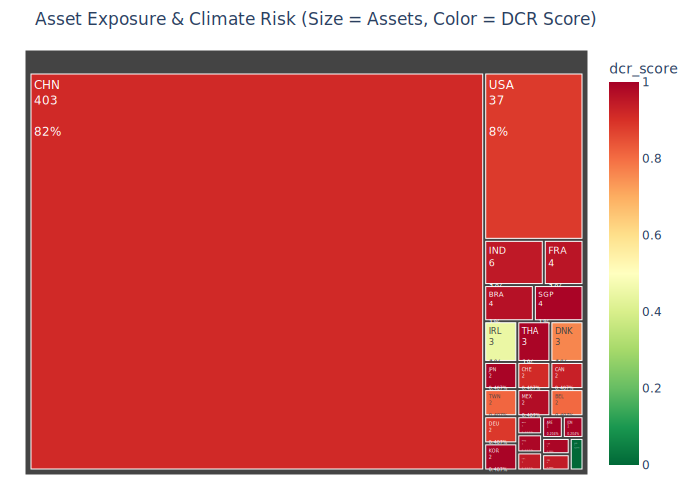

In [8]:
# Sort to emphasize high-risk areas
df_sorted = df.sort("dcr_score", descending=True)

fig = px.treemap(
    df_sorted,
    path=["country"],
    values="asset_count",
    color="dcr_score",
    color_continuous_scale="RdYlGn_r",  # Red=high risk
    hover_data=["expected_impact", "cvar_99"],
    title="Asset Exposure & Climate Risk (Size = Assets, Color = DCR Score)",
)

fig.update_traces(textinfo="label+value+percent parent")
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()